In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from scipy.stats import uniform

from jne_functions import *
from ipywidgets import interactive, FloatSlider

In [2]:
df=pd.read_csv('bank_marketing_modified.csv')
df

,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,month,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,deposit,age_group,season,pdays_bin
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,Middle-aged,spring,0
1,1,57,services,married,high.school,unknown,no,no,telephone,may,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,Middle-aged,spring,0
2,2,37,services,married,high.school,no,yes,no,telephone,may,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,Adult,spring,0
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,Middle-aged,spring,0
4,4,56,services,married,high.school,no,no,yes,telephone,may,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,Middle-aged,spring,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,41183,73,retired,married,professional.course,no,yes,no,cellular,nov,...,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,Senior,fall,0
41172,41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,...,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,Middle-aged,fall,0
41173,41185,56,retired,married,university.degree,no,yes,no,cellular,nov,...,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,Middle-aged,fall,0
41174,41186,44,technician,married,professional.course,no,no,no,cellular,nov,...,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,Middle-aged,fall,0


In [3]:
X=df.loc[:,['campaign','previous','emp.var.rate',
            'cons.price.idx','cons.conf.idx',
            'job','marital','education','poutcome',
            'default','housing','loan','month','day_of_week','pdays_bin','age_group']]
y=df['deposit']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [5]:
    numeric_features=['campaign','previous','emp.var.rate','cons.price.idx','cons.conf.idx']
    numeric_transformer= Pipeline(steps=[ ('ss',StandardScaler())])

    categorical_features=['poutcome','job','marital','education','default','housing','loan','month','day_of_week','age_group']
    categorical_transformer=OneHotEncoder(handle_unknown='error',drop='first')

    preprocessor= ColumnTransformer(
        transformers=[
            ('num',numeric_transformer,numeric_features),
            ('cat', categorical_transformer,categorical_features)
        ])

    pipe=Pipeline(steps=[('prep',preprocessor),
                        ('Berni',BernoulliNB())])
    pipe.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['campaign', 'previous',
                                                   'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['poutcome', 'job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'month',
                                                   'day_of_week',
                                       

In [6]:
def make_confusion_matrix(model, threshold=0.5):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    deposit_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(deposit_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
                xticklabels=['no', 'yes'],
                yticklabels=['no', 'yes']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [7]:
interactive(lambda threshold: make_confusion_matrix(pipe, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

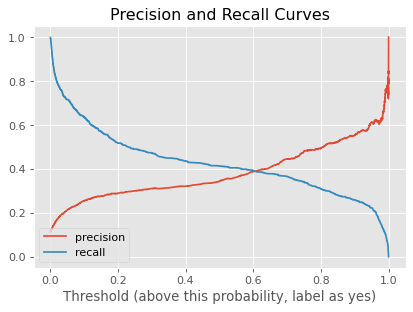

In [8]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, pipe.predict_proba(X_test)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as yes)');
plt.title('Precision and Recall Curves');

In [9]:
y_predict = pipe.predict(X_test)
f1_score(y_test, y_predict)
#0.423 with age
#0.421 without age

0.3747553816046967

In [10]:
#y_predict = (pipe.predict_proba(X_test)[:, 1] > 0.3)
#f1_score(y_test, y_predict)
#0.398 with age

In [11]:
#a higher beta more heavily weighs recall
y_predict = pipe.predict(X_test)
fbeta_score(y_test, y_predict,average='macro',beta=3)
#weighted, beta=5, 0.8194768553587276 with age
#macro, beta 3 0.7016280319381358 wtih age
# macro b=3 without age 0.7006074914846923

0.6532699580359653

In [12]:
y_predict = pipe.predict(X_test)
f1_score(y_test, y_predict, average='macro')
#0.658 with age
#0.657 without age

0.6430888080743196

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      7308
           1       0.34      0.41      0.37       928

    accuracy                           0.84      8236
   macro avg       0.63      0.66      0.64      8236
weighted avg       0.86      0.84      0.85      8236



In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:,1])

ROC AUC score =  0.7478344321527659


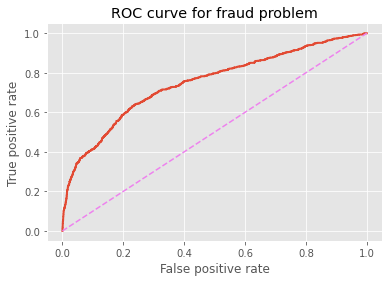

In [15]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]))

RANDOM OVERSAMPLING

In [16]:
X=df.loc[:,['campaign','previous','emp.var.rate',
            'cons.price.idx','cons.conf.idx','euribor3m',
            'nr.employed','job','marital','education','poutcome',
            'default','housing','loan','month','day_of_week','pdays_bin','age_group']]
y=df['deposit']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [18]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
ros_X_train, ros_y_train = ros.fit_sample(X_train,y_train)

In [19]:
    numeric_features=['campaign','previous','emp.var.rate','cons.price.idx','cons.conf.idx']
    numeric_transformer= Pipeline(steps=[ ('ss',StandardScaler())])

    categorical_features=['poutcome','job','marital','education','default','housing','loan','month','day_of_week','age_group']
    categorical_transformer=OneHotEncoder(handle_unknown='error',drop='first')

    preprocessor= ColumnTransformer(
        transformers=[
            ('num',numeric_transformer,numeric_features),
            ('cat', categorical_transformer,categorical_features)
        ])

    pipe=Pipeline(steps=[('prep',preprocessor),
                        ('Berni',BernoulliNB())])
    pipe.fit(ros_X_train,ros_y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['campaign', 'previous',
                                                   'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['poutcome', 'job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'month',
                                                   'day_of_week',
                                       

In [20]:
def make_confusion_matrix(model, threshold=0.5):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    deposit_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(deposit_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
                xticklabels=['no', 'yes'],
                yticklabels=['no', 'yes']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [21]:
interactive(lambda threshold: make_confusion_matrix(pipe, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

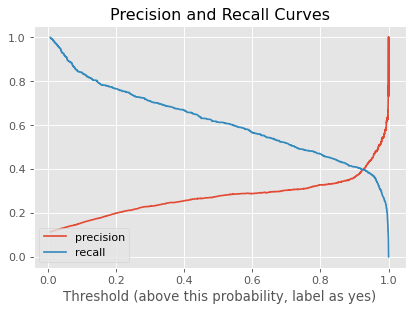

In [22]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, pipe.predict_proba(X_test)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as yes)');
plt.title('Precision and Recall Curves');

In [23]:
y_predict = pipe.predict(X_test)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86      7308
           1       0.28      0.61      0.38       928

    accuracy                           0.77      8236
   macro avg       0.61      0.70      0.62      8236
weighted avg       0.87      0.77      0.81      8236



ROC AUC score =  0.7564704569154257


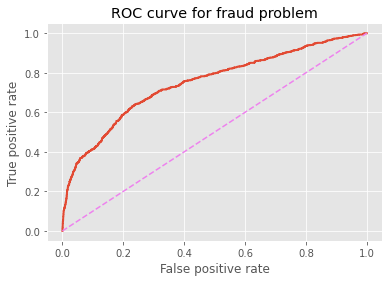

In [24]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]))